In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import mlflow
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from chesswinnerprediction.baseline.utils import (
    estimate_baseline_model,
    get_x_and_y,
    get_class_weights,
    transform_and_scale_df,
)
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.constants import DRAW_STR, PROCESSED_FOLDER_PATH
from config import BASELINE_EXPERIMENT, MLRUNS_FOLDER_PATH

## MLFlow Configuration

In [3]:
mlflow.set_tracking_uri(MLRUNS_FOLDER_PATH)

In [4]:
if mlflow.get_experiment_by_name(BASELINE_EXPERIMENT) is not None:
    experiment_id = mlflow.get_experiment_by_name(BASELINE_EXPERIMENT).experiment_id
else:
    experiment_id = mlflow.create_experiment(BASELINE_EXPERIMENT)

In [5]:
mlflow.set_experiment(experiment_id=experiment_id)
mlflow.sklearn.autolog(disable=True)

## Data Preparation

In [6]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)
mlflow.sklearn.autolog(disable=False)

In [7]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [8]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scaler=False)

In [9]:
X_train, y_train = get_x_and_y(train_data, predict_draws=True)
X_valid, y_valid = get_x_and_y(valid_data, predict_draws=True)

## Double Stage Logistic Regression

In [10]:
class Model:
    def __init__(self):
        self.win_to_draw_splitter = LogisticRegression(
            random_state=BASELINE_RANDOM_STATE,
            max_iter=50,
            class_weight="balanced",
            C=1,
            solver="liblinear",
            penalty="l2",
            tol=0.01,
        )
        self.black_to_white_splitter = LogisticRegression(
            random_state=BASELINE_RANDOM_STATE,
            max_iter=50,
            class_weight="balanced",
            C=1,
            solver="liblinear",
            penalty="l2",
            tol=0.01,
        )
        self.classes_ = None

    def fit(self, x, y):
        # Predict whether the game is a win or a draw
        win_condition = y != DRAW_STR
        self.win_to_draw_splitter.fit(x, win_condition)

        # If the game is not a draw, predict which player wins
        self.black_to_white_splitter.fit(x[win_condition], y[win_condition])

        # Set class labels
        self.classes_ = [DRAW_STR, *self.black_to_white_splitter.classes_]

    def predict_proba(self, x):
        win_probs = self.win_to_draw_splitter.predict_proba(x)

        # P(black_win) = P(black_win | win) * P(win)
        # P(white_win) = P(white_win | win) * P(win)
        classes = self.win_to_draw_splitter.classes_.tolist()
        win_prob = win_probs[:, classes.index(True)]
        draw_prob = win_probs[:, classes.index(False)]
        black_to_win_probs = (
            self.black_to_white_splitter.predict_proba(x) * win_prob[:, np.newaxis]
        )

        # according to self.classes_ :
        probs = np.zeros((x.shape[0], 3))
        probs[:, 0] = draw_prob  # set draw prob
        probs[:, 1:] = black_to_win_probs  # set black and white probs

        return probs

    def predict(self, x):
        is_win = self.win_to_draw_splitter.predict(x)

        predictions = np.full(x.shape[0], DRAW_STR, dtype=object)
        predictions[is_win] = self.black_to_white_splitter.predict(x[is_win])

        return predictions

    def estimate_model(self, x_train, y_train_data, x_valid, y_valid_data):
        feature_importance_1 = self.win_to_draw_splitter.coef_
        feature_importance_2 = self.black_to_white_splitter.coef_

        win_condition_train = y_train_data != DRAW_STR
        win_condition_valid = y_valid_data != DRAW_STR

        black_to_white_y_train = y_train_data[win_condition_train]
        black_to_white_y_valid = y_valid_data[win_condition_valid]
        black_to_white_x_train = x_train[win_condition_train]
        black_to_white_x_valid = x_valid[win_condition_valid]

        print(" " * 4, "Win to Draw Splitter:")
        estimate_baseline_model(
            self.win_to_draw_splitter,
            feature_importance_1,
            x_train,
            win_condition_train,
            x_valid,
            win_condition_valid,
        )
        print(" " * 4, "Black to White Splitter:")
        estimate_baseline_model(
            self.black_to_white_splitter,
            feature_importance_2,
            black_to_white_x_train,
            black_to_white_y_train,
            black_to_white_x_valid,
            black_to_white_y_valid,
        )
        print(" " * 4, "Overall:")
        estimate_baseline_model(self, None, X_train, y_train, X_valid, y_valid)

In [11]:
model = Model()

In [12]:
model.fit(X_train, y_train)

2024/08/09 14:29:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8fd5d583a7a74638ac5ab85de3f2439a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/08/09 14:29:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/tikhon/PycharmProjects/ChessWinnerPrediction/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/08/09 14:29:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '29986acca9b144c2a267382fbab3deef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


     Win to Draw Splitter:
Log Loss on test data: 0.6453
Balanced Accuracy on test data: 62.53%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
       False       0.04      0.67      0.08     20431              0.04      0.67      0.08      2537
        True       0.98      0.57      0.72    770253              0.98      0.58      0.73     92726
    accuracy                           0.57    790684                                  0.58     95263
   macro avg       0.51      0.62      0.40    790684              0.51      0.63      0.40     95263
weighted avg       0.96      0.57      0.71    790684              0.96      0.58      0.71     95263
       


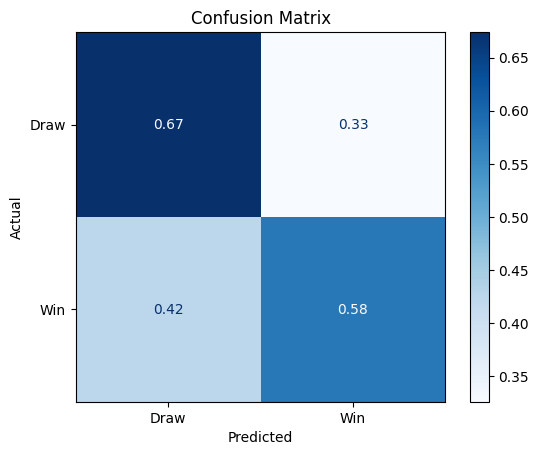

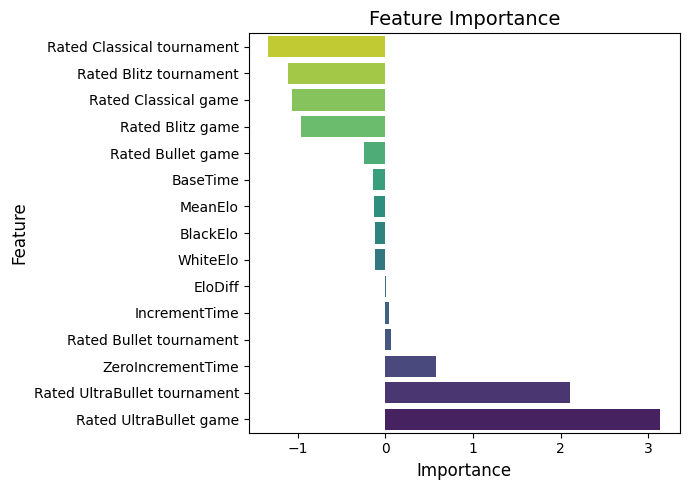

     Black to White Splitter:
Log Loss on test data: 0.6562
Balanced Accuracy on test data: 60.14%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.59      0.60      0.60    378005              0.59      0.60      0.59     45215
         1-0       0.61      0.61      0.61    392248              0.61      0.61      0.61     47511
    accuracy                           0.60    770253                                  0.60     92726
   macro avg       0.60      0.60      0.60    770253              0.60      0.60      0.60     92726
weighted avg       0.60      0.60      0.60    770253              0.60      0.60      0.60     92726
       


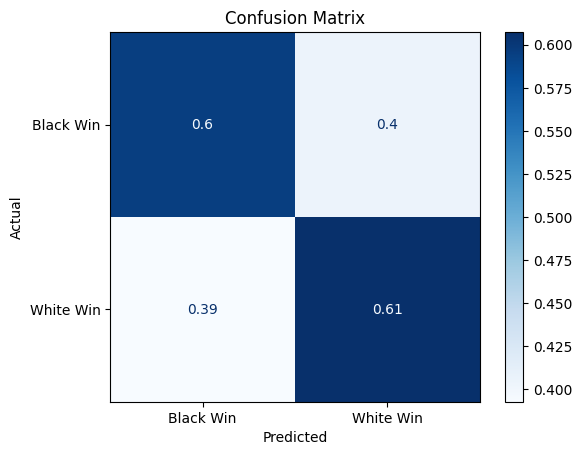

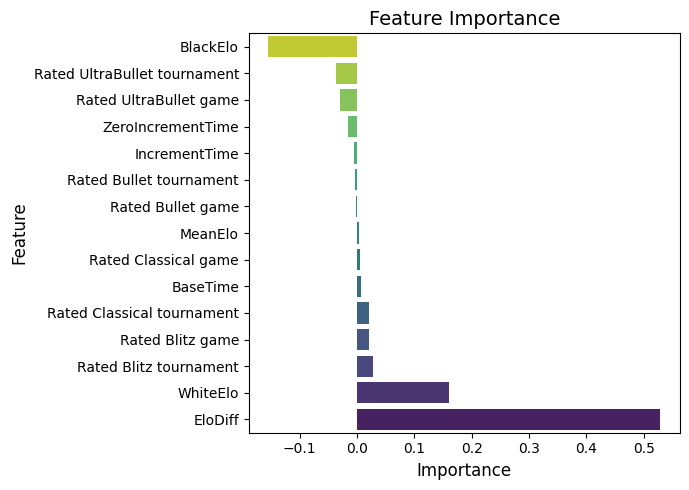

     Overall:
Log Loss on test data: 1.1919
Balanced Accuracy on test data: 45.43%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.58      0.35      0.43    378005              0.58      0.35      0.43     45215
         1-0       0.60      0.34      0.43    392248              0.60      0.34      0.44     47511
     1/2-1/2       0.04      0.67      0.08     20431              0.04      0.67      0.08      2537
    accuracy                           0.35    790684                                  0.35     95263
   macro avg       0.41      0.45      0.31    790684              0.41      0.45      0.32     95263
weighted avg       0.58      0.35      0.42    790684              0.57      0.35      0.43     95263
       


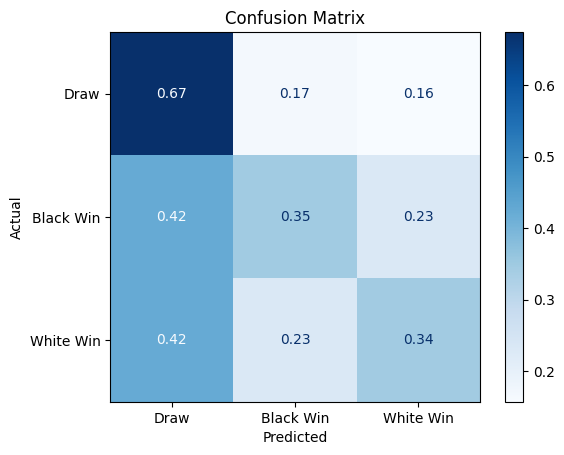

In [13]:
model.estimate_model(X_train, y_train, X_valid, y_valid)